In [93]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator
import cmcrameri.cm as cmcm
from juanfit import SpectrumFitSingle
from specutils.utils.wcs_utils import vac_to_air, air_to_vac

In [2]:
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_red_1s_proto.h5", 'r') as hf:
    bias_dc_red_1s = hf['image'][:]


In [3]:
red_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayRed2017aug21/"
helium_im_collection = ImageFileCollection(red_path,
                            glob_include="HeliumrRedpoint01s_920*.fit")
helium_im_df = helium_im_collection.summary.to_pandas()

In [4]:
helium_im_df

,file,simple,bitpix,naxis,naxis1,naxis2,bzero,bscale,datamin,datamax,...,ypixsz,xbinning,ybinning,xorgsubf,yorgsubf,xpossubf,ypossubf,cblack,cwhite,swcreate
0,HeliumrRedpoint01s_9200.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,719,14008,Artemis Capture
1,HeliumrRedpoint01s_9201.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,719,13359,Artemis Capture
2,HeliumrRedpoint01s_9202.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,723,17295,Artemis Capture
3,HeliumrRedpoint01s_9203.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,725,17460,Artemis Capture
4,HeliumrRedpoint01s_9204.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,724,15923,Artemis Capture
5,HeliumrRedpoint01s_9205.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,718,13700,Artemis Capture
6,HeliumrRedpoint01s_9206.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,718,15532,Artemis Capture
7,HeliumrRedpoint01s_9207.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,717,14252,Artemis Capture
8,HeliumrRedpoint01s_9208.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,718,13283,Artemis Capture
9,HeliumrRedpoint01s_9209.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,717,15560,Artemis Capture


In [5]:
helium_image_cube = np.zeros((1040,1392,10))

for ii, row_ in helium_im_df.iterrows():
    helium_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

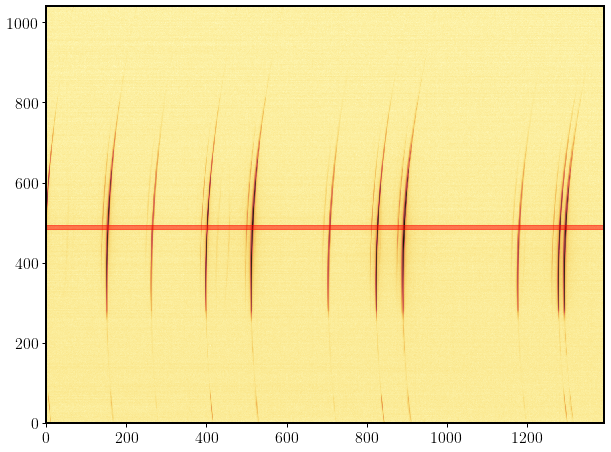

In [155]:
helium_im_aver = np.mean(helium_image_cube,axis=2)
norm = ImageNormalize(helium_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
bottom_pixel = 485
top_pixel = 495
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)

ax.tick_params(labelsize=16)

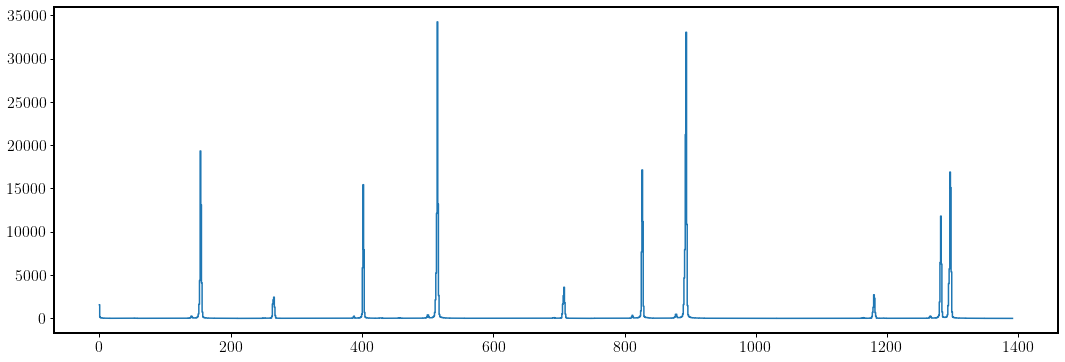

In [156]:
helium_spectrum_example = np.mean(helium_im_aver[bottom_pixel:top_pixel,:],axis=0)
fig, ax = plt.subplots(figsize=(18,6))
ccdx_array = np.arange(1392)
ax.step(ccdx_array, helium_spectrum_example,where="mid")
ax.tick_params(labelsize=16)

<AxesSubplot:ylabel='Intensity'>

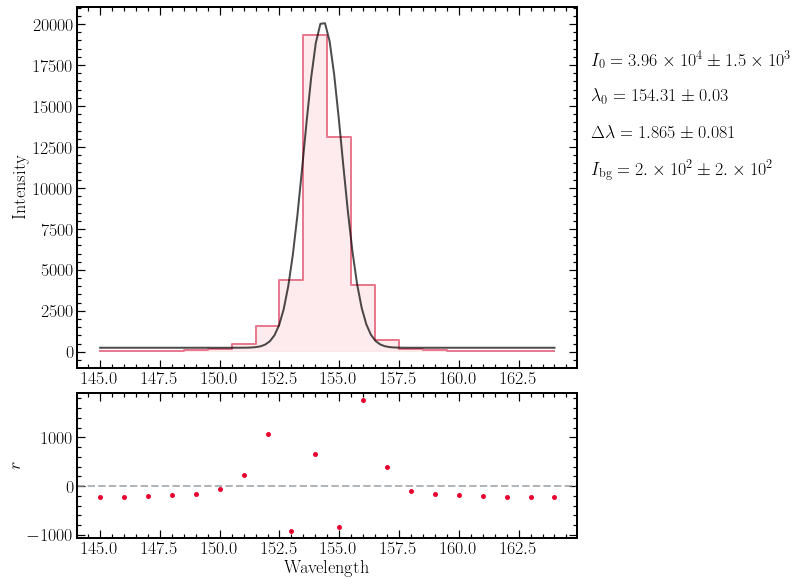

In [157]:
HeI_D3_slice_1 = slice(145,165)
HeI_D3_model_1 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_1], wvl=ccdx_array[HeI_D3_slice_1],line_number=1,line_wvl_init=[154],
                    int_max_init=[20000],fwhm_init=[1],same_width=False)
HeI_D3_model_1.run_lse(absolute_sigma=False)
HeI_D3_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

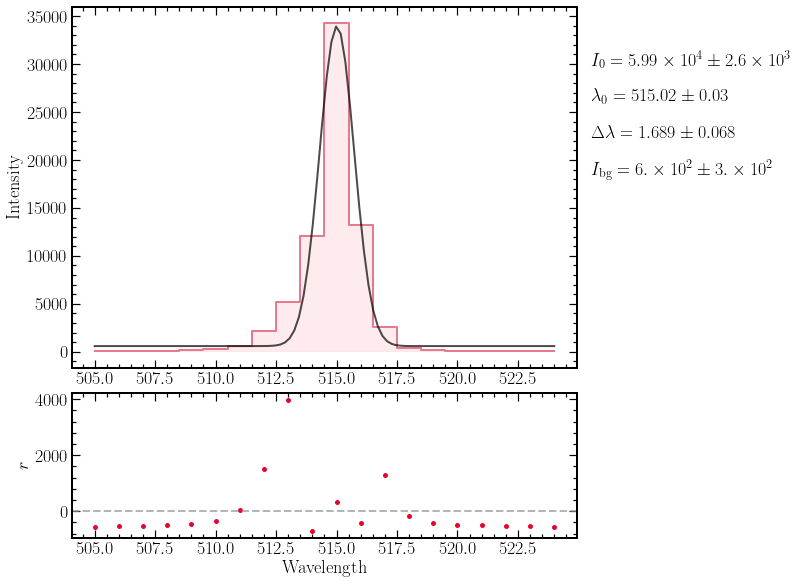

In [158]:
HeI_D3_slice_2 = slice(505,525)
HeI_D3_model_2 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_2], wvl=ccdx_array[HeI_D3_slice_2],line_number=1,line_wvl_init=[515],
                    int_max_init=[35000],fwhm_init=[1],same_width=False)
HeI_D3_model_2.run_lse(absolute_sigma=False)
HeI_D3_model_2.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

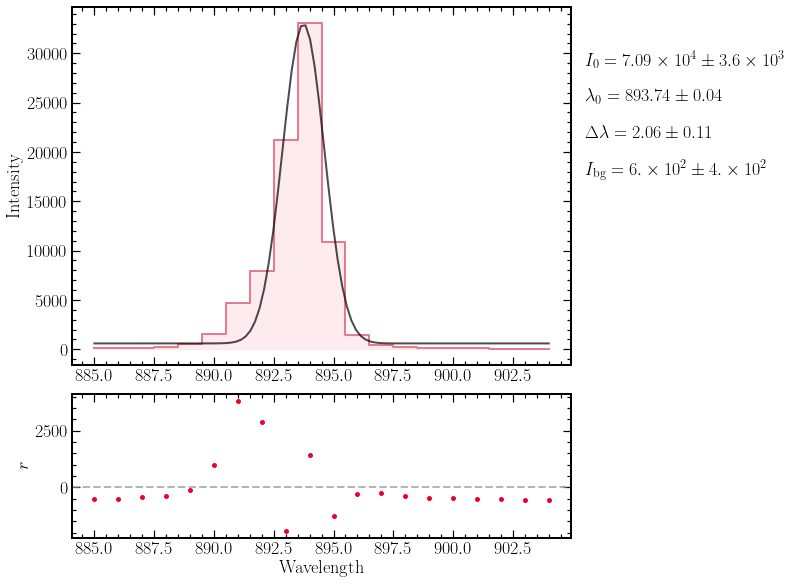

In [159]:
HeI_D3_slice_3 = slice(885,905)
HeI_D3_model_3 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_3], wvl=ccdx_array[HeI_D3_slice_3],line_number=1,line_wvl_init=[893],
                    int_max_init=[30000],fwhm_init=[2],same_width=False)
HeI_D3_model_3.run_lse(absolute_sigma=False)
HeI_D3_model_3.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

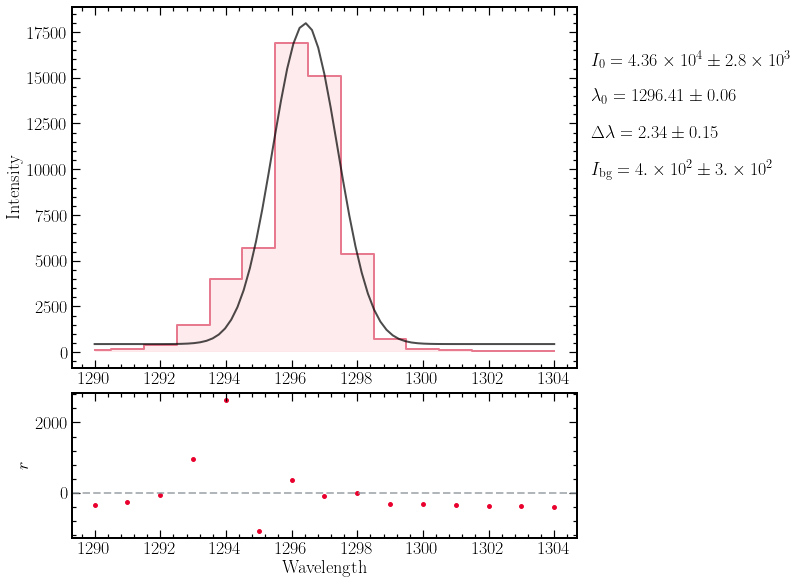

In [160]:
HeI_D3_slice_4 = slice(1290,1305)
HeI_D3_model_4 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_4], wvl=ccdx_array[HeI_D3_slice_4],line_number=1,line_wvl_init=[1297],
                    int_max_init=[17000],fwhm_init=[3],same_width=False)
HeI_D3_model_4.run_lse(absolute_sigma=False)
HeI_D3_model_4.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

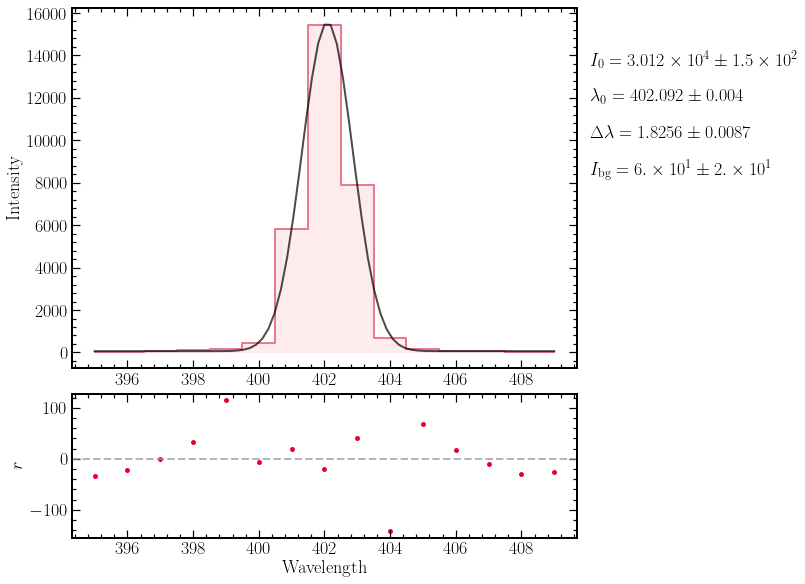

In [161]:
HeI_6678_slice_1 = slice(395,410)
HeI_6678_model_1 = SpectrumFitSingle(data=helium_spectrum_example[HeI_6678_slice_1], wvl=ccdx_array[HeI_6678_slice_1],line_number=1,line_wvl_init=[401],
                    int_max_init=[15000],fwhm_init=[1],same_width=False)
HeI_6678_model_1.run_lse(absolute_sigma=False)
HeI_6678_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

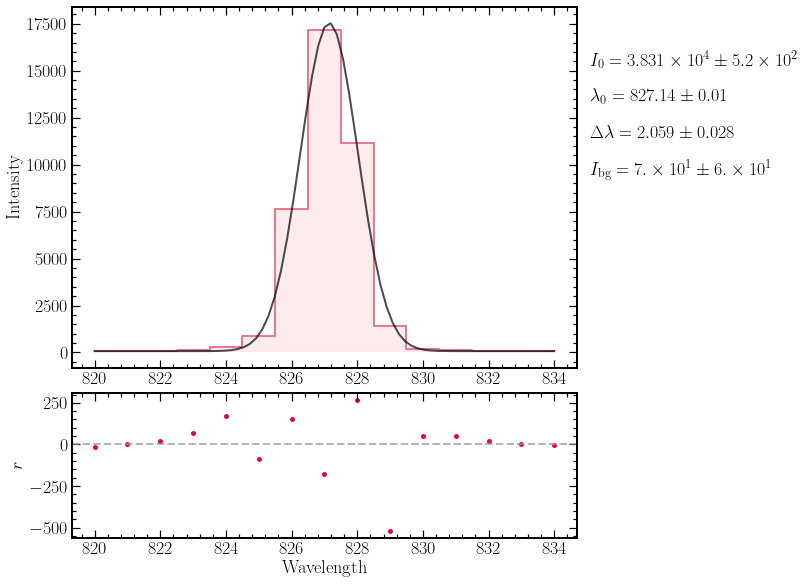

In [162]:
HeI_6678_slice_2 = slice(820,835)
HeI_6678_model_2 = SpectrumFitSingle(data=helium_spectrum_example[HeI_6678_slice_2], wvl=ccdx_array[HeI_6678_slice_2],line_number=1,line_wvl_init=[827],
                    int_max_init=[15000],fwhm_init=[3],same_width=False)
HeI_6678_model_2.run_lse(absolute_sigma=False)
HeI_6678_model_2.plot(plot_fit=True)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:204: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:ylabel='Intensity'>

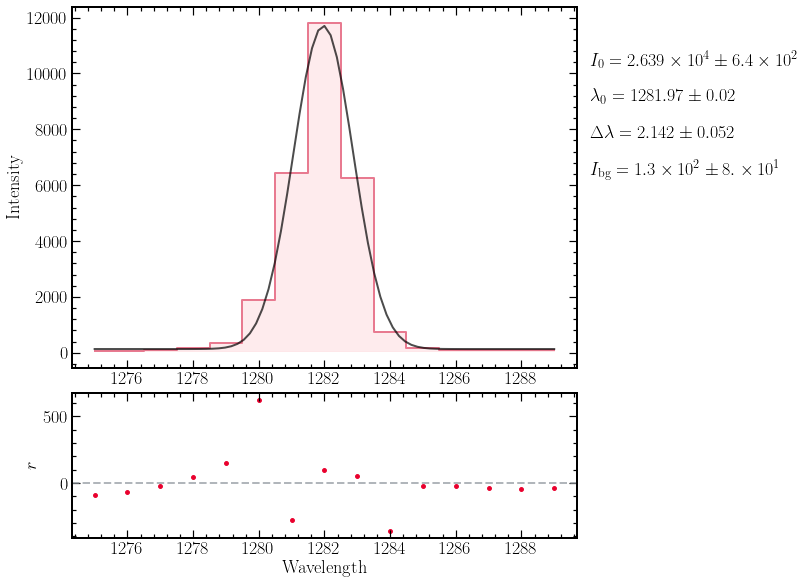

In [14]:
HeI_6678_slice_3 = slice(1275,1290)
HeI_6678_model_3 = SpectrumFitSingle(data=helium_spectrum_example[HeI_6678_slice_3], wvl=ccdx_array[HeI_6678_slice_3],line_number=1,line_wvl_init=[1282],
                    int_max_init=[12000],fwhm_init=[3],same_width=False)
HeI_6678_model_3.run_lse(absolute_sigma=True)
HeI_6678_model_3.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

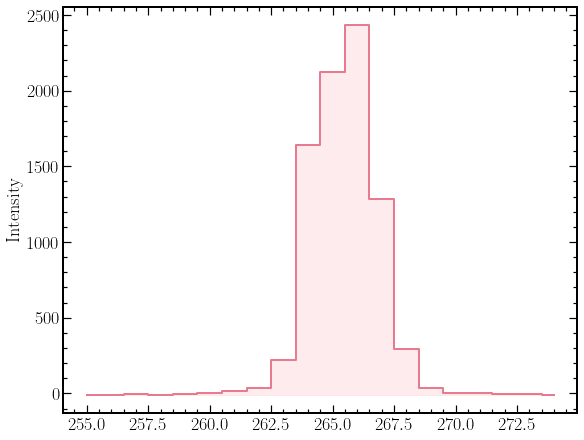

In [66]:
HeI_7066_slice_1 = slice(255,275)
HeI_7066_model_1 = SpectrumFitSingle(data=helium_spectrum_example[HeI_7066_slice_1], wvl=ccdx_array[HeI_7066_slice_1],line_number=1,line_wvl_init=[401],
                    int_max_init=[15000],fwhm_init=[1],same_width=False)
# HeI_7066_model_1.run_lse(absolute_sigma=False)
HeI_7066_model_1.plot(plot_fit=False)

In [15]:
HeI_D3_pos = np.array([HeI_D3_model.line_wvl_fit[0] for HeI_D3_model in 
                    (HeI_D3_model_1, HeI_D3_model_2, HeI_D3_model_3, HeI_D3_model_4)])
                    
HeI_6678_pos = np.array([HeI_6678_model.line_wvl_fit[0] for HeI_6678_model in 
                    (HeI_6678_model_1, HeI_6678_model_2, HeI_6678_model_3)])

In [16]:
HeI_D3_pos

array([ 154.31419268,  515.01609079,  893.74283925, 1296.41486911])

In [17]:
HeI_D3_pos[1:] - HeI_D3_pos[:-1]

array([360.70189811, 378.72674846, 402.67202986])

In [18]:
HeI_6678_pos

array([ 402.09207718,  827.14391142, 1281.96722751])

In [19]:
HeI_6678_pos[1:] - HeI_6678_pos[:-1]

array([425.05183424, 454.82331609])

In [20]:
hydrogen_im_collection = ImageFileCollection(red_path,
                            glob_include="HydrogenRedpoint1s_947*.fit")
hydrogen_im_df = hydrogen_im_collection.summary.to_pandas()

In [21]:
hydrogen_im_df

,file,simple,bitpix,naxis,naxis1,naxis2,bzero,bscale,datamin,datamax,...,ypixsz,xbinning,ybinning,xorgsubf,yorgsubf,xpossubf,ypossubf,cblack,cwhite,swcreate
0,HydrogenRedpoint1s_9470.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,726,25799,Artemis Capture
1,HydrogenRedpoint1s_9471.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,730,24838,Artemis Capture
2,HydrogenRedpoint1s_9472.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,730,24237,Artemis Capture
3,HydrogenRedpoint1s_9473.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,732,25086,Artemis Capture
4,HydrogenRedpoint1s_9474.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,732,25004,Artemis Capture
5,HydrogenRedpoint1s_9475.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,726,24843,Artemis Capture
6,HydrogenRedpoint1s_9476.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,723,24729,Artemis Capture
7,HydrogenRedpoint1s_9477.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,724,24676,Artemis Capture
8,HydrogenRedpoint1s_9478.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,728,23696,Artemis Capture
9,HydrogenRedpoint1s_9479.fit,True,16,2,1392,1040,32768.0,1.0,0.0,65535.0,...,6.45,1,1,0,0,0,0,726,26298,Artemis Capture


In [22]:
hydrogen_image_cube = np.zeros((1040,1392,10))

for ii, row_ in hydrogen_im_df.iterrows():
    hydrogen_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

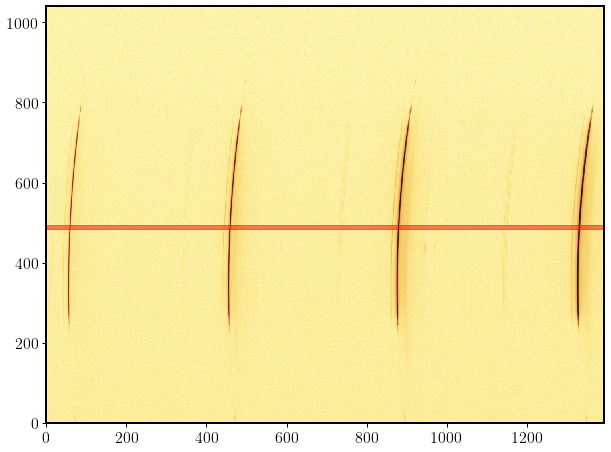

In [23]:
hydrogen_im_aver = np.mean(hydrogen_image_cube,axis=2)
norm = ImageNormalize(hydrogen_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
bottom_pixel = 485
top_pixel = 495
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)

ax.tick_params(labelsize=16)

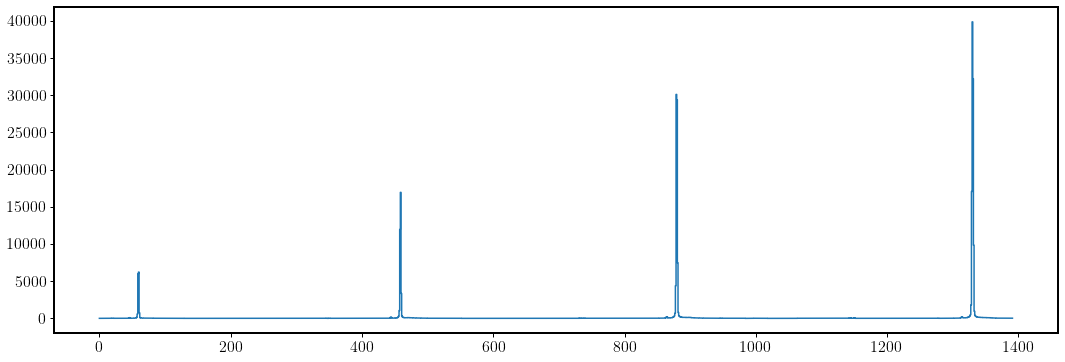

In [24]:
hydrogen_spectrum_example = np.mean(hydrogen_im_aver[bottom_pixel:top_pixel,:],axis=0)
fig, ax = plt.subplots(figsize=(18,6))
ccdx_array = np.arange(1392)
ax.step(ccdx_array, hydrogen_spectrum_example,where="mid")
ax.tick_params(labelsize=16)

<AxesSubplot:ylabel='Intensity'>

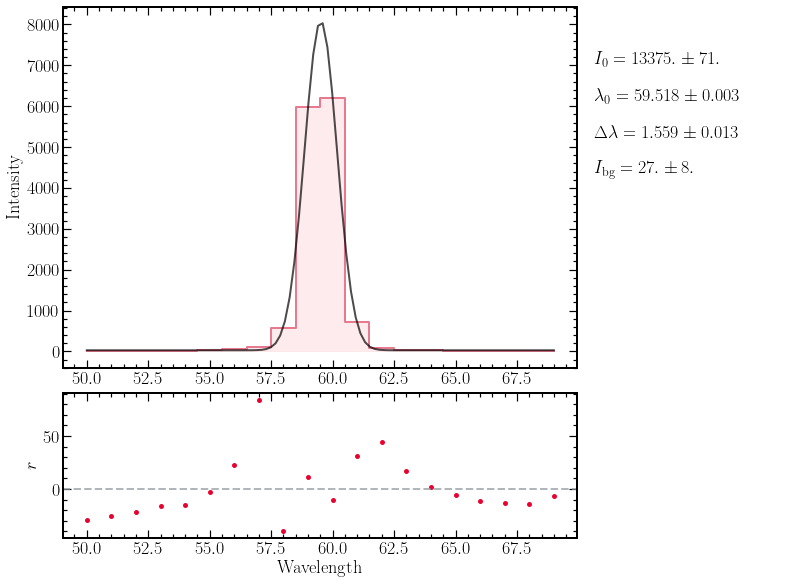

In [25]:
Halpha_slice_1 = slice(50,70)
Halpha_model_1 = SpectrumFitSingle(data=hydrogen_spectrum_example[Halpha_slice_1], wvl=ccdx_array[Halpha_slice_1],line_number=1,line_wvl_init=[59],
                    int_max_init=[6000],fwhm_init=[1],same_width=False)
Halpha_model_1.run_lse(absolute_sigma=False)
Halpha_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

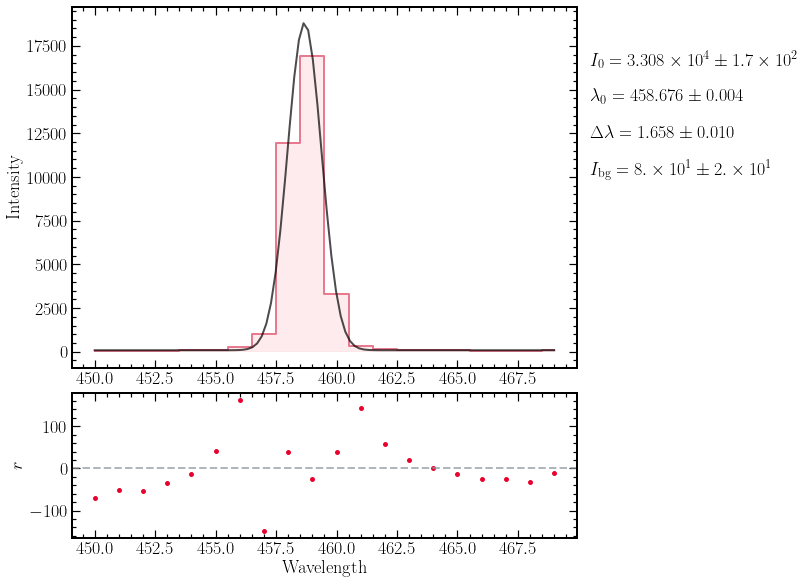

In [26]:
Halpha_slice_2 = slice(450,470)
Halpha_model_2 = SpectrumFitSingle(data=hydrogen_spectrum_example[Halpha_slice_2], wvl=ccdx_array[Halpha_slice_2],line_number=1,line_wvl_init=[458],
                    int_max_init=[17000],fwhm_init=[1],same_width=False)
Halpha_model_2.run_lse(absolute_sigma=False)
Halpha_model_2.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

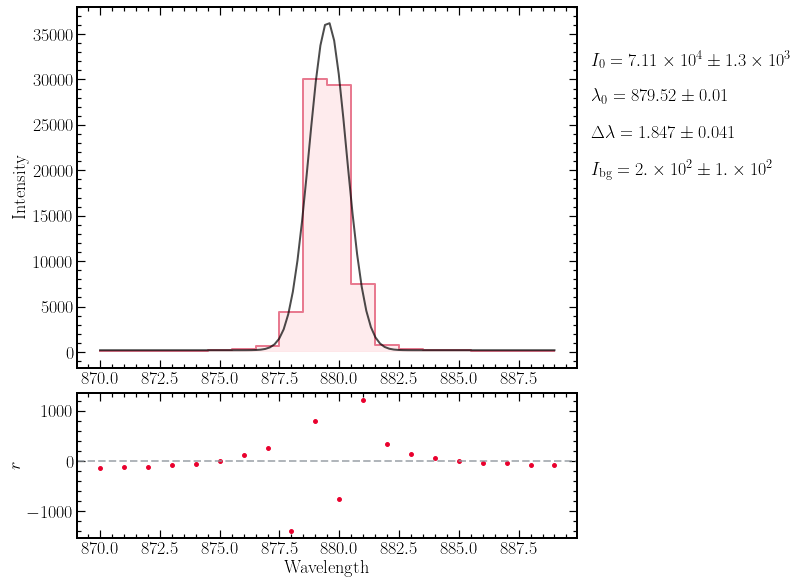

In [27]:
Halpha_slice_3 = slice(870,890)
Halpha_model_3 = SpectrumFitSingle(data=hydrogen_spectrum_example[Halpha_slice_3], wvl=ccdx_array[Halpha_slice_3],line_number=1,line_wvl_init=[880],
                    int_max_init=[30000],fwhm_init=[1],same_width=False)
Halpha_model_3.run_lse(absolute_sigma=False)
Halpha_model_3.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

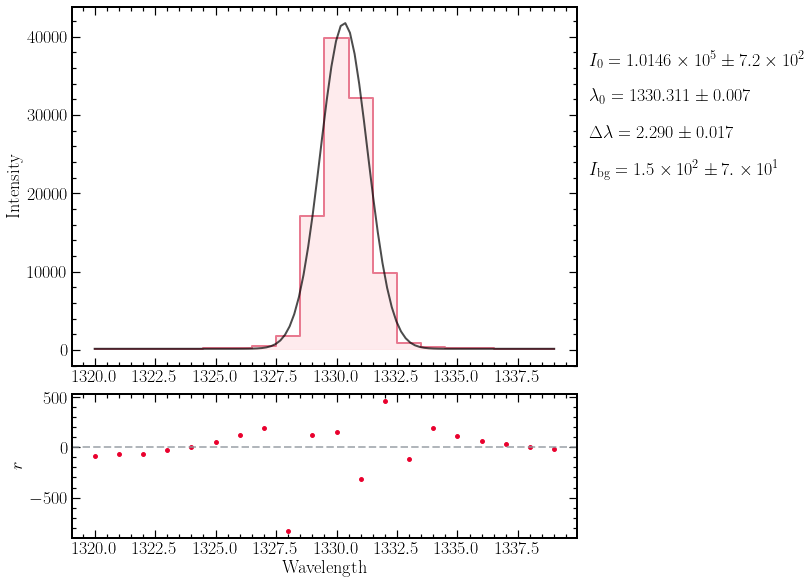

In [28]:
Halpha_slice_4 = slice(1320,1340)
Halpha_model_4 = SpectrumFitSingle(data=hydrogen_spectrum_example[Halpha_slice_4], wvl=ccdx_array[Halpha_slice_4],line_number=1,line_wvl_init=[1330],
                    int_max_init=[40000],fwhm_init=[1],same_width=False)
Halpha_model_4.run_lse(absolute_sigma=False)
Halpha_model_4.plot(plot_fit=True)

In [29]:
Halpha_pos = np.array([Halpha_model.line_wvl_fit[0] for Halpha_model in 
                    (Halpha_model_1, Halpha_model_2, Halpha_model_3, Halpha_model_4)])

In [30]:
Halpha_pos[1:] - Halpha_pos[:-1]

array([399.15802902, 420.84046487, 450.79407522])

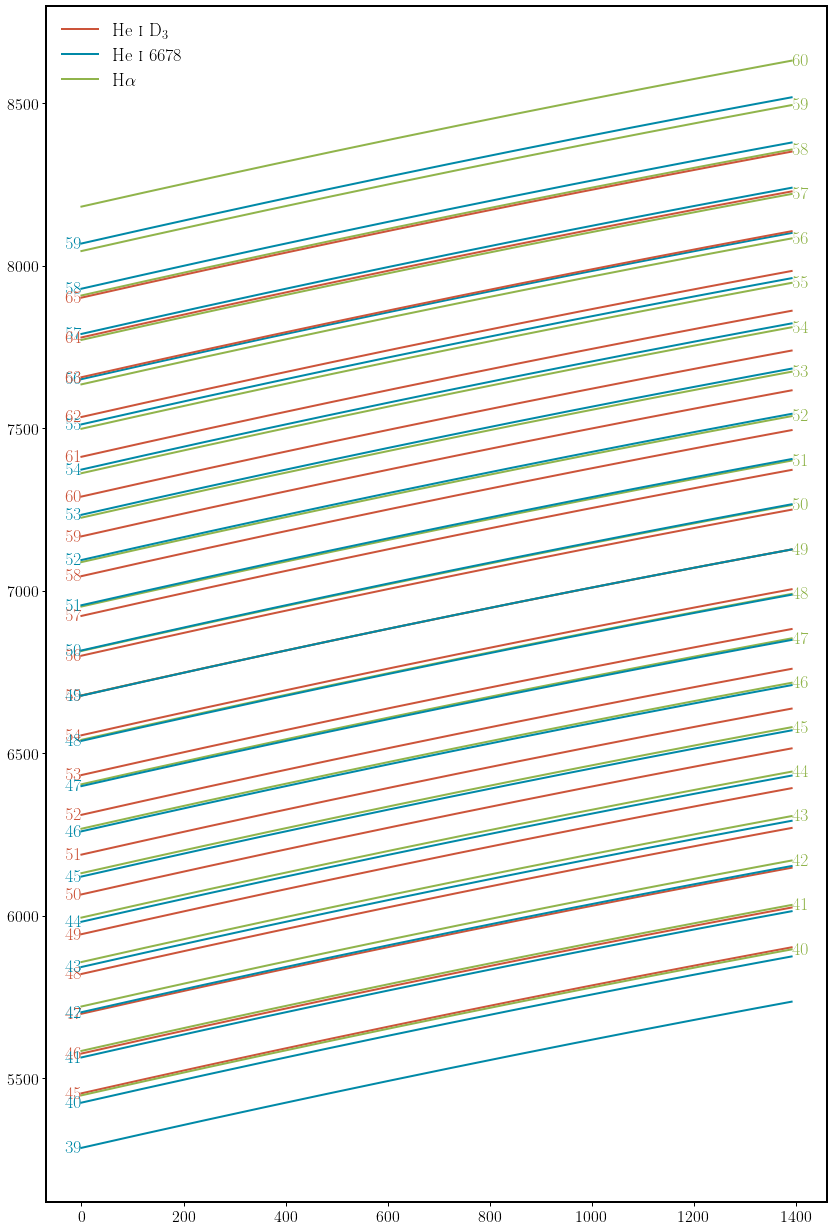

In [31]:
scale_factor = 48
HeI_D3_start_order_guess = 55
HeI_6678_start_order_guess = 49
Halpha_start_order_guess = 50

order_variation = 10
fig, ax = plt.subplots(figsize=(14,order_variation*2 + 2))

for ii, order_new in enumerate(np.arange(-order_variation, order_variation + 1)):
    HeI_D3_wvl_guess_new = 5875.621 * np.arange(HeI_D3_start_order_guess + order_new,
                             HeI_D3_start_order_guess + order_new + 4 )/scale_factor
    HeI_6678_wvl_guess_new = 6678.151 * np.arange(HeI_6678_start_order_guess + order_new,
                                HeI_6678_start_order_guess + order_new +3)/scale_factor
    Halpha_wvl_guess_new = 6562.79  * np.arange(Halpha_start_order_guess + order_new,
                             Halpha_start_order_guess + order_new + 4 )/scale_factor
    
    poly_fit_d3_param = np.polyfit(HeI_D3_pos, HeI_D3_wvl_guess_new, 2)
    poly_fit_d3_func = np.poly1d(poly_fit_d3_param)
    poly_fit_d3_curve = poly_fit_d3_func(ccdx_array)

    poly_fit_6678_param = np.polyfit(HeI_6678_pos, HeI_6678_wvl_guess_new, 2)
    poly_fit_6678_func = np.poly1d(poly_fit_6678_param)
    poly_fit_6678_curve = poly_fit_6678_func(ccdx_array)

    poly_fit_halpha_param = np.polyfit(Halpha_pos, Halpha_wvl_guess_new, 2)
    poly_fit_halpha_func = np.poly1d(poly_fit_halpha_param)
    poly_fit_halpha_curve = poly_fit_halpha_func(ccdx_array)

    ln1, = ax.plot(ccdx_array, poly_fit_d3_curve,color="#CC543A",lw=2,
            label=r"He \textsc{i} $\rm D_3$")
    ax.text(0, poly_fit_d3_curve[0],"{:2d}".format(HeI_D3_start_order_guess + order_new),
            va="center",ha="right",fontsize=18,color="#CC543A")

    ln2, = ax.plot(ccdx_array, poly_fit_6678_curve,color="#0089A7",lw=2,
            label=r"He \textsc{i} 6678")
    ax.text(0, poly_fit_6678_curve[0],"{:2d}".format(HeI_6678_start_order_guess + order_new),
            va="center",ha="right",fontsize=18,color="#0089A7")

    ln3, = ax.plot(ccdx_array, poly_fit_halpha_curve,color="#90B44B",lw=2,
            label=r"H$\alpha$")
    ax.text(1392, poly_fit_halpha_curve[-1],"{:2d}".format(Halpha_start_order_guess + order_new),
            va="center",ha="left",fontsize=18,color="#90B44B")

    if ii == order_variation*2:
        leg = [ln1,ln2,ln3]
        ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 18,frameon=False)

ax.tick_params(labelsize=16)



Text(0, 0.5, 'Wavelength $\\lambda$\\,[\\mbox{\\AA}]')

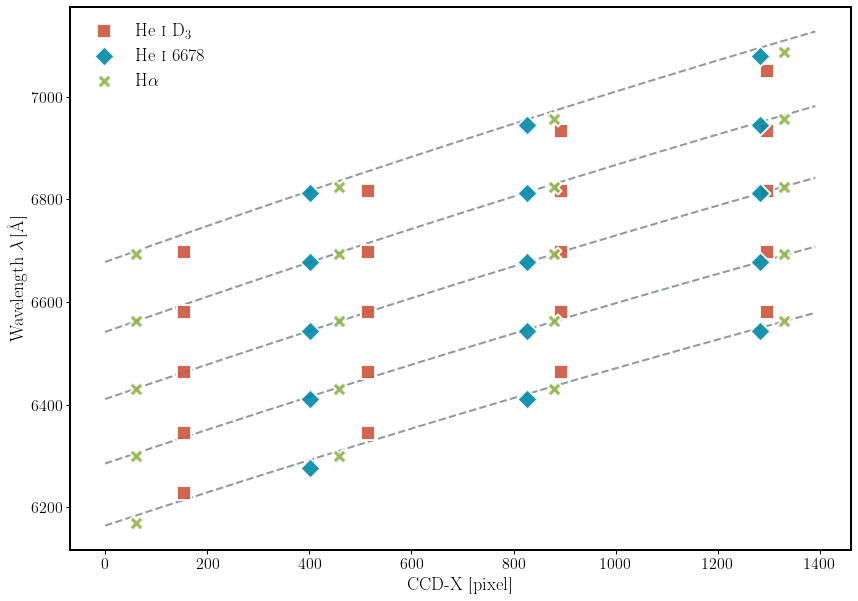

In [107]:
base_order = 50
HeI_D3_start_order_guess = 55
HeI_6678_start_order_guess = 49
Halpha_start_order_guess = 49

HeI_D3_wvl_guess = 5875.621 * np.arange(HeI_D3_start_order_guess, HeI_D3_start_order_guess + 4)/base_order
HeI_6678_wvl_guess = 6678.151 * np.arange(HeI_6678_start_order_guess, HeI_6678_start_order_guess + 3)/base_order
Halpha_wvl_guess = 6562.79 * np.arange(Halpha_start_order_guess, Halpha_start_order_guess + 4)/base_order

line_pos_all = np.concatenate([HeI_D3_pos, HeI_6678_pos,Halpha_pos])
line_wvl_guess_all = np.concatenate([HeI_D3_wvl_guess, HeI_6678_wvl_guess,Halpha_wvl_guess])

poly_fit_param = np.polyfit(line_pos_all, line_wvl_guess_all, 2)
poly_fit_func = np.poly1d(poly_fit_param)
poly_fit_curve = poly_fit_func(ccdx_array)

order_variation = 2
fig, ax = plt.subplots(figsize=(14,order_variation*4 + 2))


for ii, order_new in enumerate(np.arange(-order_variation, order_variation + 1)):
    HeI_D3_wvl_guess_new = 5875.621 * np.arange(HeI_D3_start_order_guess + order_new,
                             HeI_D3_start_order_guess + order_new + 4 )/base_order
    HeI_6678_wvl_guess_new = 6678.151 * np.arange(HeI_6678_start_order_guess + order_new,
                                HeI_6678_start_order_guess + order_new +3)/base_order
    Halpha_wvl_guess_new = 6562.79 * np.arange(Halpha_start_order_guess + order_new,
                                Halpha_start_order_guess + order_new +4)/base_order

    ln1 = ax.scatter(HeI_D3_pos, HeI_D3_wvl_guess_new,marker= "s",s=200,facecolor="#CC543A",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"He \textsc{i} $\rm D_3$")
    ln2 = ax.scatter(HeI_6678_pos, HeI_6678_wvl_guess_new,marker= "D",s=200,facecolor="#0089A7",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"He \textsc{i} 6678")
    ln3 = ax.scatter(Halpha_pos, Halpha_wvl_guess_new,marker= "X",s=200,facecolor="#90B44B",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"H$\alpha$")
    if ii == order_variation*2:
        leg = [ln1,ln2,ln3]
        ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 18,frameon=False)

    ax.plot(ccdx_array, poly_fit_curve*base_order/(base_order + order_new),lw=2,ls="--",color="#91989F",zorder=0)


# for plot_order in np.arange(base_order - 5, base_order + 5):
#     ax.scatter()

ax.tick_params(labelsize=16)
ax.set_xlabel("CCD-X [pixel]",fontsize=18)
ax.set_ylabel(r"Wavelength $\lambda$\,[\mbox{\AA}]",fontsize=18)

In [67]:
totality_image_fname = "TotalitySequenceRed_7723.fit"
totality_frame = CCDData.read(os.path.join(red_path, totality_image_fname),unit="adu")

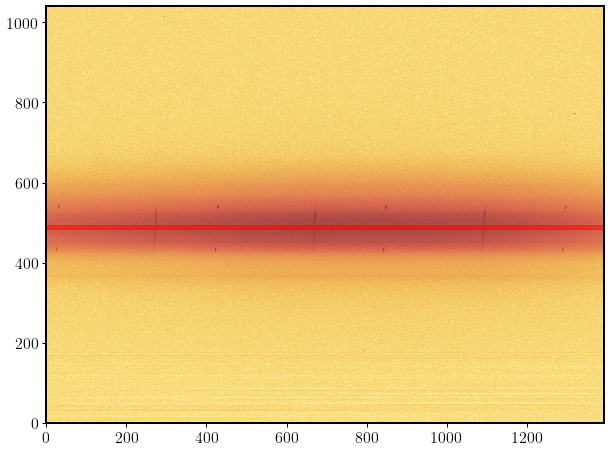

In [70]:
totality_image = (totality_frame.data - bias_dc_red_1s)//totality_frame.header["EXPTIME"]
norm = ImageNormalize(totality_image, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),totality_image,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
bottom_pixel = 485
top_pixel = 495
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)
ax.tick_params(labelsize=16)

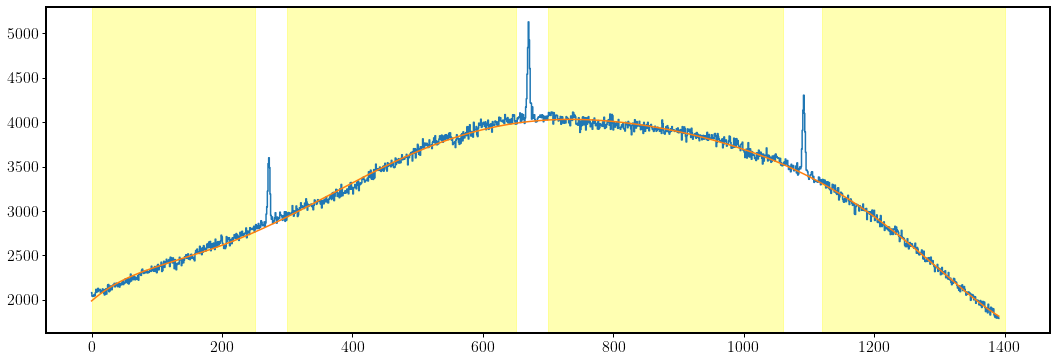

In [78]:
totality_spectrum_example = np.mean(totality_image[bottom_pixel:top_pixel,:],axis=0)
fig, ax = plt.subplots(figsize=(18,6))
ccdx_array = np.arange(1392)
ax.step(ccdx_array, totality_spectrum_example,where="mid")
ax.tick_params(labelsize=16)

fit_intervals = [slice(0,250),slice(300,650),slice(700,1060),slice(1120,1400)]
for fit_interval in fit_intervals:
    ax.axvspan(fit_interval.start,fit_interval.stop,color="yellow",alpha=0.3)

background_poly_order = 7
wvl_array_to_fit = np.concatenate([ccdx_array[fit_interval] for fit_interval in fit_intervals])
spectra_to_fit = np.concatenate([totality_spectrum_example[fit_interval] for fit_interval in fit_intervals])
background_poly_params = np.polyfit(wvl_array_to_fit,spectra_to_fit,background_poly_order)
background_poly_func = np.poly1d(background_poly_params)
background_poly_curve = background_poly_func(ccdx_array)

ax.plot(ccdx_array, background_poly_curve, label="{:.0f}th".format(background_poly_order))

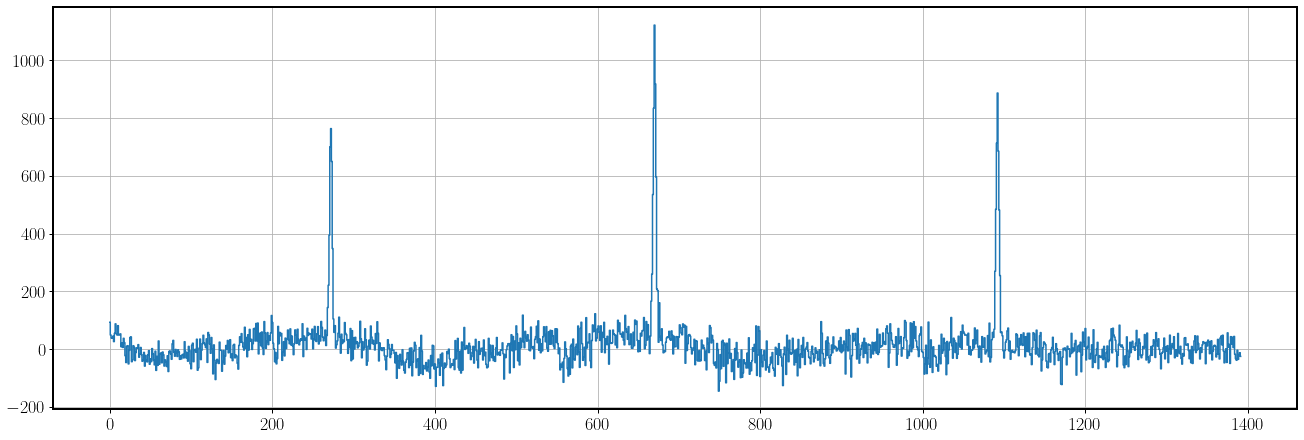

In [80]:
totality_spectrum_no_background = totality_spectrum_example - background_poly_curve
fig, ax = plt.subplots(figsize=(18,6),constrained_layout=True)
ax.step(ccdx_array, totality_spectrum_no_background, where="mid")
ax.tick_params(labelsize=18)
ax.grid("on")

<AxesSubplot:ylabel='Intensity'>

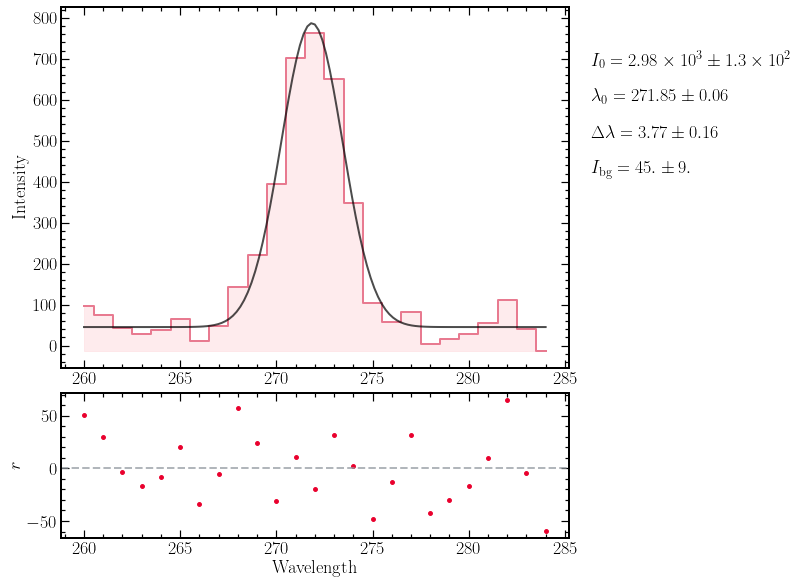

In [86]:
FeX_6374_slice_1 = slice(260,285)
FeX_6374_model_1 = SpectrumFitSingle(data=totality_spectrum_no_background[FeX_6374_slice_1], wvl=ccdx_array[FeX_6374_slice_1],line_number=1,line_wvl_init=[272],
                    int_max_init=[700],fwhm_init=[1],same_width=False)
FeX_6374_model_1.run_lse(absolute_sigma=False)
FeX_6374_model_1.plot(plot_fit=True)

In [95]:
poly_fit_func(FeX_6374_model_1.line_wvl_fit[0])*48/6374.51

51.00169589581506

In [94]:
vac_to_air(6376.2900*u.Angstrom)

<Quantity 6374.43055223 Angstrom>

<AxesSubplot:ylabel='Intensity'>

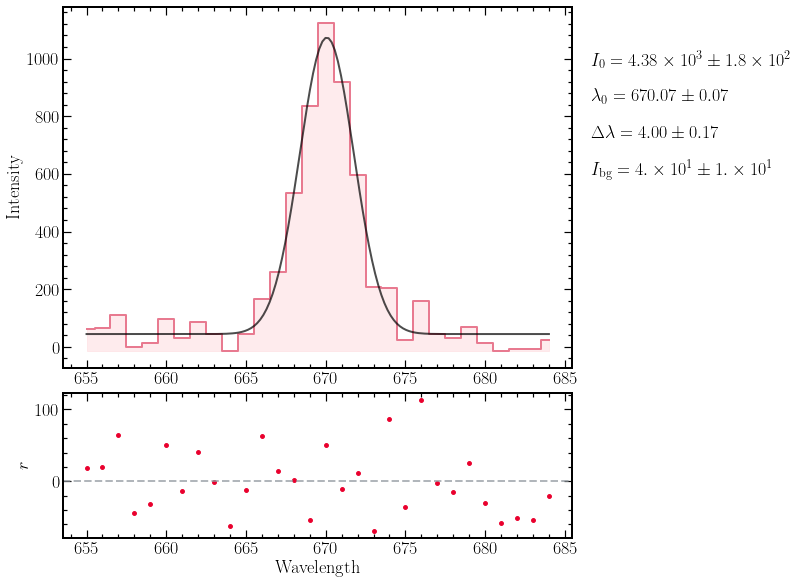

In [90]:
FeX_6374_slice_2 = slice(655,685)
FeX_6374_model_2 = SpectrumFitSingle(data=totality_spectrum_no_background[FeX_6374_slice_2], wvl=ccdx_array[FeX_6374_slice_2],line_number=1,line_wvl_init=[670],
                    int_max_init=[1000],fwhm_init=[1],same_width=False)
FeX_6374_model_2.run_lse(absolute_sigma=False)
FeX_6374_model_2.plot(plot_fit=True)

In [96]:
poly_fit_func(FeX_6374_model_2.line_wvl_fit[0])*48/6374.51

52.001433634171484

In [ ]:
poly_fit_func(FeX_6374_model_2.line_wvl_fit[0])*48/6374.51

<AxesSubplot:ylabel='Intensity'>

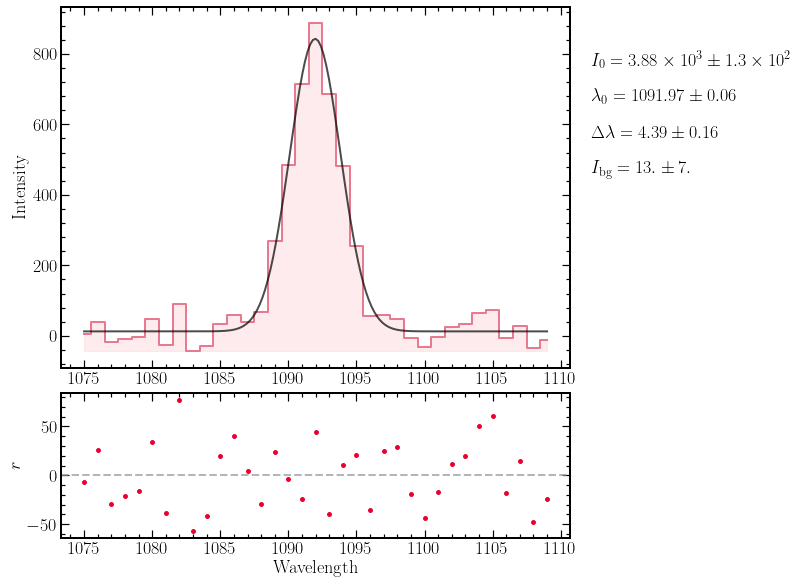

In [103]:
FeX_6374_slice_3 = slice(1075,1110)
FeX_6374_model_3 = SpectrumFitSingle(data=totality_spectrum_no_background[FeX_6374_slice_3], wvl=ccdx_array[FeX_6374_slice_3],line_number=1,line_wvl_init=[1092],
                    int_max_init=[8000],fwhm_init=[3],same_width=False)
FeX_6374_model_3.run_lse(absolute_sigma=False)
FeX_6374_model_3.plot(plot_fit=True)

In [104]:
poly_fit_func(FeX_6374_model_3.line_wvl_fit[0])*48/6374.51

52.999916390634084

In [109]:
FeX_6374_pos = np.array([FeX_6374_model.line_wvl_fit[0] for FeX_6374_model in 
                    (FeX_6374_model_1, FeX_6374_model_2, FeX_6374_model_3)])


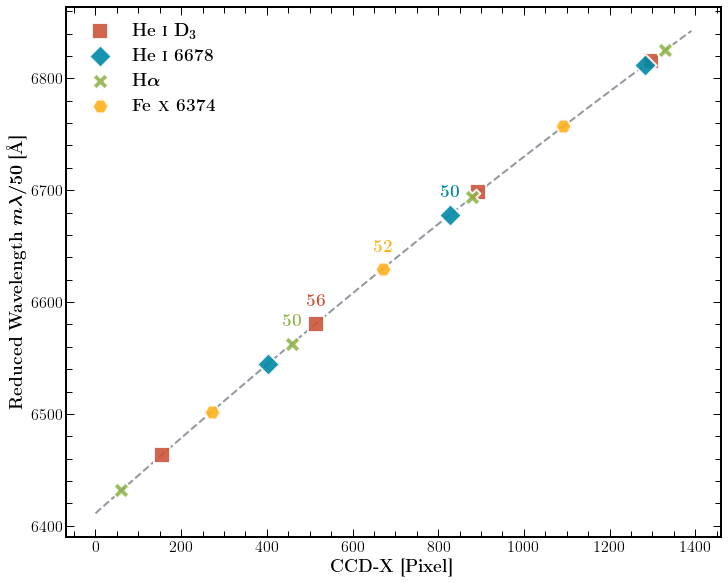

In [143]:
FeX_6374_start_order_guess = 51
FeX_6374_wvl_guess = 6374.51 * np.arange(FeX_6374_start_order_guess, FeX_6374_start_order_guess + 3)/base_order

fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)

ln1 = ax.scatter(HeI_D3_pos, HeI_D3_wvl_guess,marker= "s",s=250,facecolor="#CC543A",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{He \textsc{i}} $\boldsymbol{\rm D_3}$")
ln2 = ax.scatter(HeI_6678_pos, HeI_6678_wvl_guess,marker= "D",s=250,facecolor="#0089A7",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{He \textsc{i} 6678}")
ln3 = ax.scatter(Halpha_pos, Halpha_wvl_guess,marker= "X",s=250,facecolor="#90B44B",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{H}$\boldsymbol{\alpha}$")
ln4 = ax.scatter(FeX_6374_pos, FeX_6374_wvl_guess,marker= "H",s=250,facecolor="#FFB11B",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{Fe \textsc{x} 6374}")

leg = [ln1,ln2,ln3,ln4]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 18,frameon=False)

ax.plot(ccdx_array, poly_fit_curve,lw=2,ls="--",color="#91989F",zorder=0)
ax.text(Halpha_pos[1], Halpha_wvl_guess[1]+20, r"\textbf{{{:2d}}}".format(Halpha_start_order_guess+1),color="#90B44B",
        fontsize=18,ha="center",va="center")
ax.text(HeI_D3_pos[1], HeI_D3_wvl_guess[1]+20, r"\textbf{{{:2d}}}".format(HeI_D3_start_order_guess+1),color="#CC543A",
        fontsize=18,ha="center",va="center")
ax.text(HeI_6678_pos[1], HeI_6678_wvl_guess[1]+20, r"\textbf{{{:2d}}}".format(HeI_6678_start_order_guess+1),color="#0089A7",
        fontsize=18,ha="center",va="center")
ax.text(FeX_6374_pos[1], FeX_6374_wvl_guess[1]+20, r"\textbf{{{:2d}}}".format(FeX_6374_start_order_guess+1),color="#FFB11B",
        fontsize=18,ha="center",va="center")

ax.tick_params(labelsize=16,direction="in",which="both",right=True,top=True)
ax.tick_params(length=8,which="major")
ax.tick_params(length=6,which="minor")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel(r"\textbf{Reduced Wavelength} $\boldsymbol{m\lambda/50}$ \textbf{[\mbox{\AA}]}",fontsize=18)
ax.set_xlabel(r"\textbf{CCD-X [Pixel]}",fontsize=18)
plt.savefig(fname="../../figs/calib/wvl_calib_red_eclipse_2017.pdf",dpi=300)